## Background :

The behavior of customers and booking options have thoroughly altered by the online hotel reservation channels. A significant number of reservations are canceled always, mostly due to cancellations or no-shows. Cancellations can be caused by a variety of factors, such as scheduling conflicts, changes in plans, etc. This is observed more frequently due to the fact that hotels often make it easier for guests to cancel their reservations by offering free or low cost cancellation options. Although this benefits the guests heavily, it may risk the hotel losing on potential revenue.

Therefore, the outcome of this project is to assist the hotel owners to better understand whether a customer will confirm the booking or cancel it by developing and implementing machine learning methodologies.

**Source : The dataset used in this project is from Kaggle. Link -\>** [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv)

### Importing the necessary libraries


In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.metrics import (
    f1_score,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option("display.max_colwidth", 0)
from sklearn.feature_selection import RFECV

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from IPython.display import display, HTML
import shap, eli5

### Exploratory data analysis:

In this exploratory data analysis (EDA) section, we load the training dataset from a CSV file and prepare it for analysis. We split the data into training and testing sets, with 70% allocated for training. Then, we provide a summary of the descriptive statistics for the training dataset to gain insights into its distribution and characteristics.


In [2]:
data = pd.read_csv("train__dataset.csv")
X = data.drop("booking_status", axis=1)
y = data["booking_status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111, train_size = 0.7) # setting a random state to make it reproducible

df_train = X_train.join(y_train)
df_train.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000,12695.000000
mean,1.845845,0.106892,0.808980,2.214100,0.313037,0.031902,0.336510,84.945884,2017.821189,7.441985,15.628909,0.806459,0.026073,0.022922,0.159354,103.513689,0.616384,0.324143
std,0.517027,0.410776,0.871795,1.418276,0.623953,0.175747,0.774089,85.788163,0.383209,3.081619,8.779931,0.645516,0.159359,0.379929,1.785368,35.090118,0.790173,0.468072
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.750000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,125.000000,2018.000000,10.000000,23.000000,1.000000,0.000000,0.000000,0.000000,120.000000,1.000000,1.000000
max,4.000000,9.000000,6.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,375.500000,5.000000,1.000000


Based on the summary statistics provided, here are some initial observations about the data: \* There are 12,695 observations in the train dataset. \* The average number of adults per booking is 1.85 while the average number of children per booking is 0.11 <br/> \* On average people visit between July and August, meaning the hotel is busier during summer holidays. \* The average number of nights stayed over a weekend is 0.81 while the average number of nights stayed during the week is 2.21 <br/> \* The average lead time for bookings is 84.95 days, with a standard deviation of 85.79. <br/> \* Only 2.6% of bookings are from repeated guests on average <br/> \* The average price per room is 103.51 <br/> \* The majority of bookings (67.6%) are confirmed, while the remaining 32.4% are canceled. <br/>

## Data visualization:

To identify patterns or trends in the data relative to target class, we can create visualisations of some features for each target classes to see the differences between them.

### Outlier Analysis of Numerical Features:


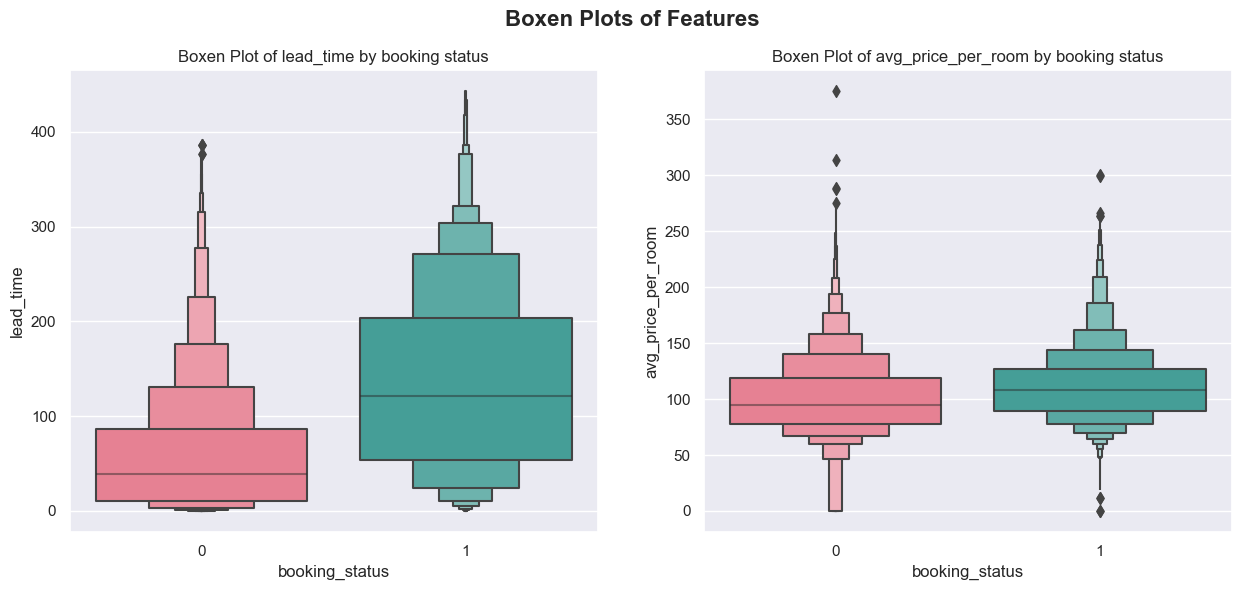

In [17]:
# Define the features
sns.set_theme(style="darkgrid")
features = ['lead_time', 'avg_price_per_room']
fig, axes = plt.subplots(nrows = 1, ncols=len(features), figsize=(15, 6))
fig.suptitle("Boxen Plots of Features", fontsize=16, fontweight='bold')

# Iterate over features
for i, feature in enumerate(features):
    sns.boxenplot(data=df_train, y = feature, x = 'booking_status', palette="husl", ax=axes[i])
    axes[i].set_title("Boxen Plot of " + feature + " by booking status")

The provided boxen plots offer insights into booking behavior based on lead time and average room price. For lead time, bookings not cancelled tend to have shorter lead times, possibly indicating last-minute reservations, while cancelled bookings show longer and more varied lead times, suggesting advanced bookings with diverse lead times. For average room price, non-cancelled bookings exhibit similar median prices as cancelled bookings. This insight challenges the initial observation and prompts the need for further analysis to better understand guest booking preferences and cancellation behaviors.

### Distribution Analysis of Numerical Features:


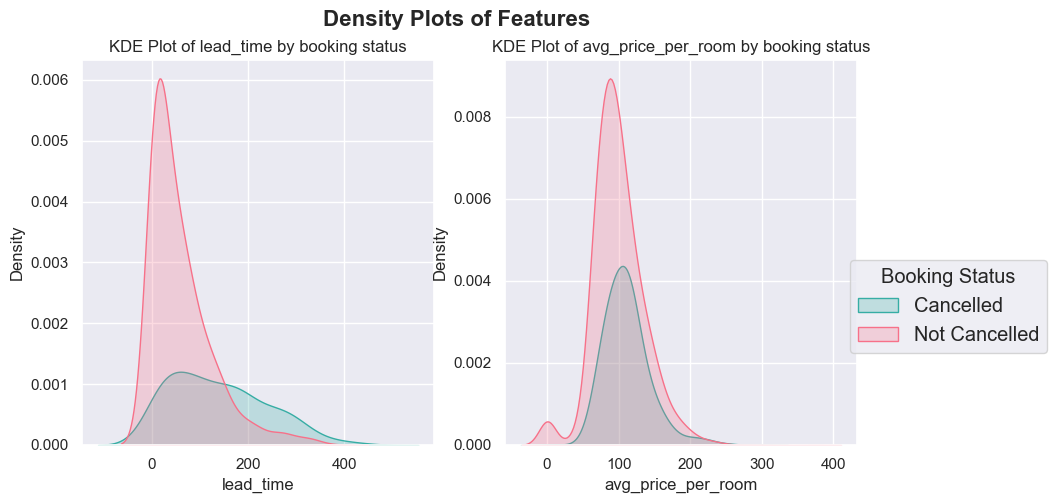

In [18]:
# Define the features
features = ['lead_time', 'avg_price_per_room']
fig, axes = plt.subplots(nrows = 1, ncols=len(features), figsize=(10, 5))
fig.suptitle("Density Plots of Features", fontsize=16, fontweight='bold')

# Iterate over features
for i, feature in enumerate(features):
    sns.kdeplot(data=df_train, x=feature, hue="booking_status", bw_adjust=2, fill=True, palette="husl", ax=axes[i],
                legend=False)
    axes[i].set_title("KDE Plot of " + feature + " by booking status")
fig.legend(title = "Booking Status", labels=["Cancelled", "Not Cancelled"], bbox_to_anchor=(1.1, 0.5), fontsize = "large", title_fontsize='large')

The histograms reveal distinct patterns in booking behavior and cancellation likelihood based on lead time and average room price. For lead time, bookings are predominantly confirmed when the interval between booking and arrival is short, with cancellations becoming more prevalent as lead time increases beyond 100 days. Conversely, guests are more likely to confirm bookings when the lead time is under 100 days. Regarding average room price, confirmed bookings consistently outnumber cancellations across all price ranges. However, the highest confirmation rates occur when the average room price falls between 50 and 125. Beyond this range, cancellation probabilities increase, approaching parity with confirmation probabilities. In summary, shorter lead times and moderate room prices between 50 and 125 are associated with higher confirmation rates, while longer lead times are associated with increased cancellation probabilities. These insights can inform hotel management strategies to optimize booking processes and minimize cancellation rates.

### Distribution Analysis of Categorical Features:


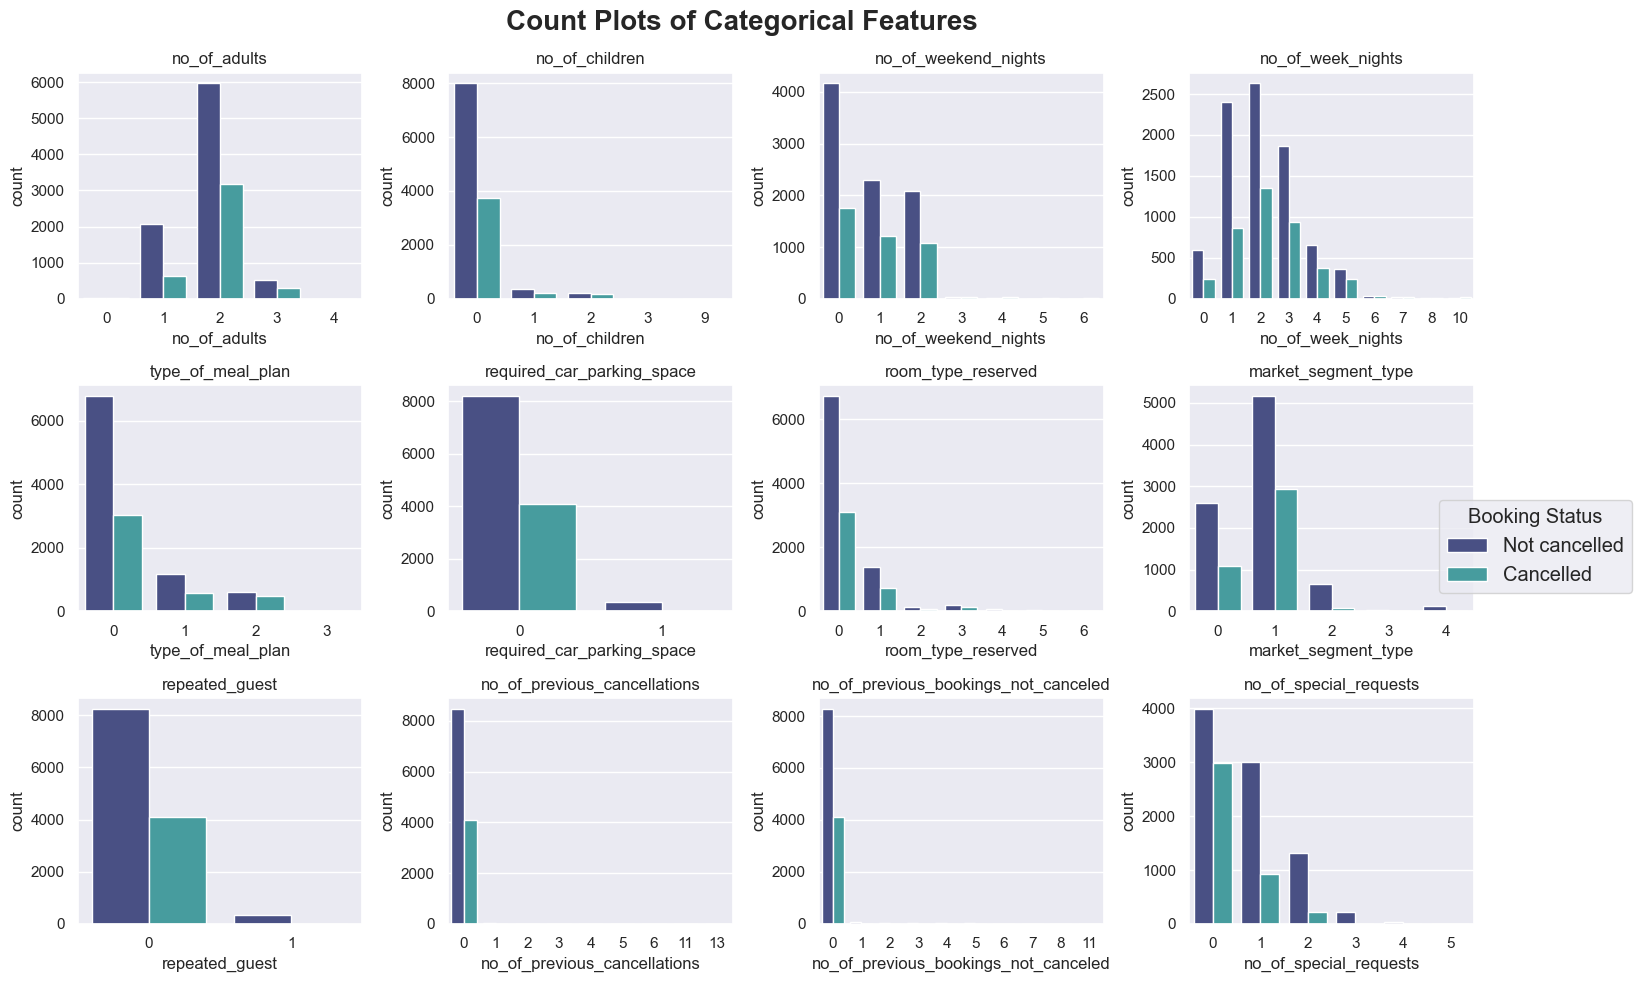

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the categorical features
cat_features = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 
                'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 
                'market_segment_type', 'repeated_guest', 'no_of_previous_cancellations', 
                'no_of_previous_bookings_not_canceled', 'no_of_special_requests']

# Create subplots with 3 rows and 4 columns
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
fig.suptitle("Count Plots of Categorical Features", fontsize=20, fontweight='bold')

# Iterate over features
for i, feature in enumerate(cat_features):
    # Filter the DataFrame to include only the top N most frequent categories
    top_categories = df_train[feature].value_counts().index[:10]
    filtered_df = df_train[df_train[feature].isin(top_categories)]
    
    row = i // 4  # Calculate the row index
    col = i % 4   # Calculate the column index
    sns.countplot(data=filtered_df, x=feature, hue="booking_status", palette="mako", ax=axes[row, col])
    axes[row, col].set_title(feature)
    axes[row, col].legend().set_visible(False)

fig.legend(title = "Booking Status", labels=["Not cancelled", "Cancelled"], bbox_to_anchor=(1.1, 0.5), fontsize = "large", title_fontsize='large')
plt.tight_layout()
plt.show()

Based on the bar plots:

1.  **Number of Adults and Children**: Most bookings are made for one or two adults, and very few include children. This suggests that the hotel is primarily used by adults, possibly for business or couples on vacation.

2.  **Number of Weekend Nights and Week Nights**: Guests typically stay from one to four nights during both weekends and weekdays. This could indicate that the hotel is popular for short stays.

3.  **Type of Meal Plan**: A specific type of meal plan is predominantly chosen by guests. This could be due to the convenience or cost-effectiveness of this plan.

4.  **Required Car Parking Space**: A large number of guests do not require car parking spaces, which might suggest that many guests use public transportation or other means of travel.

5.  **Room Type Reserved**: Various room types are reserved with one being more common. This could indicate a preference for a particular room type, possibly due to cost, size, or amenities.

6.  **Market Segment Type**: There's a notable difference in market segment types between cancelled and not cancelled bookings. This could suggest that certain market segments are more likely to cancel their bookings.

7.  **Repeated Guest**: Most guests are not repeated ones, indicating that the hotel has a diverse guest population.

8.  **Number of Previous Cancellations and Bookings Not Cancelled**: A majority have zero previous cancellations and many have no prior non-cancelled reservations. This could suggest that most guests are first-time visitors.

9.  **Number of Special Requests**: Special requests during stays are relatively uncommon, which might indicate that most guests' needs are met by the standard amenities provided by the hotel.

These observations provide valuable insights into the hotel's guest demographics and their preferences, which could be useful for making strategic decisions to improve guest satisfaction and business performance. However, these are just observations based on the given plots, and further analysis would be needed to draw more concrete conclusions.

## Modeling:

### Preprocessing and transformations:


In [60]:
numeric_features = ["no_of_adults", "no_of_children","no_of_weekend_nights","no_of_week_nights", "lead_time", "no_of_previous_cancellations","no_of_previous_bookings_not_canceled","avg_price_per_room","no_of_special_requests", "arrival_month"] # apply scaling
categorical_features = ["type_of_meal_plan", "room_type_reserved", "market_segment_type"] # apply one-hot encoding
binary_features = ["required_car_parking_space", "repeated_guest"] # apply one-hot encoding with drop="if_binary"
drop_features = ["arrival_year", "arrival_date"] # customers make bookings depending on mostly months  
target = "booking_status"

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
binary_transformer = OneHotEncoder(drop="if_binary", dtype=int)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    (binary_transformer, binary_features),
    ("drop", drop_features),
)

We separate features into numerical and categorical types because they require different types of transformations. We apply one-hot encoding on the categorical features and standard scaling on the numerical features. In this project, we will approach different methods and employ different models. One of such models is a logistic regression model.

Below is a helper function to make calculating validation scores easier:


In [61]:
def mean_std_cross_val_scores(model, X_train, y_train, scoring, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """
    if scoring == "f1":
        scores = cross_validate(model, X_train, y_train, scoring = "f1", **kwargs)
        mean_scores = pd.DataFrame(scores).mean()
        std_scores = pd.DataFrame(scores).std()
        out_col = []

        for i in range(len(mean_scores)):
            out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

        return pd.Series(data=out_col, index=mean_scores.index)
    else:
        scores = cross_validate(model, X_train, y_train, **kwargs)

        mean_scores = pd.DataFrame(scores).mean()
        std_scores = pd.DataFrame(scores).std()
        out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

### Linear models:


In [62]:
results_dict = {}
C_vals = 10.0 ** np.arange(-2, 2, 0.5)

for C in C_vals:
    lr_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, C=C))
    results_dict["Logistic Regression with C=" + str(C)] = mean_std_cross_val_scores(
        lr_pipe, X_train, y_train, return_train_score=True, scoring ="accuracy"
    )
    
pd.DataFrame(results_dict)

,Logistic Regression with C=0.01,Logistic Regression with C=0.03162277660168379,Logistic Regression with C=0.1,Logistic Regression with C=0.31622776601683794,Logistic Regression with C=1.0,Logistic Regression with C=3.1622776601683795,Logistic Regression with C=10.0,Logistic Regression with C=31.622776601683793
fit_time,0.033 (+/- 0.005),0.035 (+/- 0.002),0.048 (+/- 0.002),0.066 (+/- 0.003),0.095 (+/- 0.007),0.132 (+/- 0.007),0.164 (+/- 0.007),0.161 (+/- 0.023)
score_time,0.007 (+/- 0.002),0.006 (+/- 0.001),0.006 (+/- 0.000),0.006 (+/- 0.000),0.006 (+/- 0.001),0.006 (+/- 0.000),0.005 (+/- 0.001),0.006 (+/- 0.000)
test_score,0.798 (+/- 0.009),0.800 (+/- 0.007),0.802 (+/- 0.006),0.802 (+/- 0.006),0.803 (+/- 0.006),0.803 (+/- 0.006),0.803 (+/- 0.006),0.803 (+/- 0.006)
train_score,0.798 (+/- 0.003),0.800 (+/- 0.003),0.803 (+/- 0.003),0.803 (+/- 0.002),0.804 (+/- 0.002),0.804 (+/- 0.002),0.804 (+/- 0.002),0.804 (+/- 0.002)


From the above observations, we can conclude that changing C values after a specific threshold does not affect the training scores. Thus, we should try optimizing a different hyperparameter or try using another model and optimize it to get a better model.

Therefore, we try using another model with a different estimator. Since linear models seemed to be at its limit, we can improve our results by exploring the use of non-linear estimators and evaluating their effectiveness.

### Non-linear models:


In [63]:
results_dict = {}
models = {
    "Decision Trees": DecisionTreeClassifier(random_state=111),
    "kNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_jobs=-1, n_estimators=100, random_state = 111)
}

for x in models:
    for y in ["accuracy", "f1"]:
        pipe = make_pipeline(preprocessor, models[x])
        results_dict[x + " " + str(y)] = mean_std_cross_val_scores(
            pipe, X_train, y_train, return_train_score=True, scoring = y)
        
pd.DataFrame(results_dict)

,Decision Trees accuracy,Decision Trees f1,kNN accuracy,kNN f1,Random Forest accuracy,Random Forest f1
fit_time,0.046 (+/- 0.005),0.043 (+/- 0.001),0.015 (+/- 0.002),0.015 (+/- 0.000),1.133 (+/- 1.820),0.314 (+/- 0.008)
score_time,0.006 (+/- 0.001),0.007 (+/- 0.000),0.163 (+/- 0.001),0.163 (+/- 0.001),0.035 (+/- 0.001),0.035 (+/- 0.002)
test_score,0.845 (+/- 0.005),0.763 (+/- 0.007),0.832 (+/- 0.006),0.732 (+/- 0.008),0.883 (+/- 0.006),0.810 (+/- 0.010)
train_score,0.996 (+/- 0.000),0.994 (+/- 0.001),0.882 (+/- 0.002),0.812 (+/- 0.004),0.996 (+/- 0.000),0.994 (+/- 0.001)


Based on the mean test scores, Random Forest seems to be performing the best, with an mean test score around 0.883. This is followed by Decision Trees with a score 0.845, and kNN with a score 0.832. Random Forest also have the best f1 score meaning that it can correctly identify both positive and negative examples with the highest accuracy among the rest of the models.

Given that the Random Forest model is the most effective among other models, we will focus on optimizing its hyperparameters to improve its performance.

### Optimization:

We will look to optimize the hyperparameters max_depth, n_estimators and class_weight. We will use random search, an automated technique to find the best set of hyperparameters.


In [64]:
rf = RandomForestClassifier(n_jobs=-1, random_state=111)
ac_search_results = []
best_accuracy = 0
best_accuracy_params = []

f1_search_results =[]
best_f1 = 0
best_f1_params = []

param_grid = {"randomforestclassifier__max_depth": [10, 20, 30, 40, 50],
             "randomforestclassifier__n_estimators": [50, 100, 200, 250, 300],
             "randomforestclassifier__class_weight": [None, {0:1, 1:3},'balanced']}

pipe = make_pipeline(preprocessor, rf)
random_search = RandomizedSearchCV(
    pipe, param_grid, cv=5, return_train_score=True, n_iter=15, random_state=111
)
random_search.fit(X_train, y_train)
for x in ["accuracy", "f1"]:
    pipe = make_pipeline(preprocessor, rf)
    random_search = RandomizedSearchCV(
        pipe, param_grid, cv=5, return_train_score=True, n_iter=15, random_state=111, scoring = x
    )
    random_search.fit(X_train, y_train)
    if x == "accuracy":
        ac_search_results = pd.DataFrame(random_search.cv_results_)
        best_accuracy = random_search.best_score_
        best_accuracy_params = random_search.best_params_
    else:
        f1_search_results = pd.DataFrame(random_search.cv_results_)
        best_f1 = random_search.best_score_
        best_f1_params = random_search.best_params_

In [65]:
print(best_accuracy_params, best_accuracy)
print(best_f1_params, best_f1)

{'randomforestclassifier__n_estimators': 250, 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__class_weight': 'balanced'} 0.8844426939740055
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_depth': 20, 'randomforestclassifier__class_weight': {0: 1, 1: 3}} 0.8158630987451104


At first glance, the accuracy is more improved than the what we got intially. Also, the f1 increased slightly. The best f1 params and accuracy params differ by just the class weight. Looking at the f1_search_results and ac_search\_ results, the difference between the accuracies and f1 scores between these two params is trivial for both optimum parameters. Therefore, we pick the best f1 params as the accuracy score (for best f1 params) is slightly lower than its best score. Also, we can afford to lose a very small accuracy score for a better f1 score. Moreover, using lower n_estimators will make fitting faster.

**Therefore, the final optimized model:** `RandomForestClassifier(n_estimators = 200, max_depth=20, class_weight = {0: 1, 1: 3})`

### Feature importances and selection:

An important part of this project involved creating and transforming the features used in our model, given a rather large amount of raw data. First, we need to find which features are important to the model. Then, we will use feature selection to select specific features to make our model simpler and better.

#### Feature importances:

We will use eli5 to view which features are important.


In [74]:
X_train_pp = preprocessor.fit_transform(X_train)

column_names = numeric_features + list(
    preprocessor.named_transformers_["onehotencoder-1"].get_feature_names_out(categorical_features)) + list(
    preprocessor.named_transformers_["onehotencoder-2"].get_feature_names_out(binary_features))

pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(n_estimators = 200, max_depth=20, n_jobs=-1, random_state=111, class_weight = {0: 1, 1: 3}))
pipe_rf.fit(X_train, y_train)
exp_df = eli5.explain_weights_df(pipe_rf.named_steps["randomforestclassifier"], feature_names=column_names)

vscrollbar = {
 'selector': '',
 'props': ' height: 240px; overflow-y: scroll;display: inline-block;'
}

exp_df.style.set_table_styles([vscrollbar])

,feature,weight,std
0,lead_time,0.330100,0.022381
1,avg_price_per_room,0.163066,0.018598
2,no_of_special_requests,0.130147,0.023908
3,arrival_month,0.103653,0.011179
4,no_of_week_nights,0.058911,0.007677
5,no_of_weekend_nights,0.043598,0.007356
6,market_segment_type_1,0.036235,0.024143
7,no_of_adults,0.024855,0.006412
8,market_segment_type_0,0.022669,0.017395
9,required_car_parking_space_1,0.012265,0.003019


From the table: \* lead_time, avg_price_per_room, no_of_special_requests and arrival month have the highest weight among all the features(\>0.1). \* no_of_week_nights, no_of_weekend_nights , market_segment_type_1, and no_of_adults have moderate to low weight. \* The rest of the features have very low to no weight. \* lead_time is the most important feature, followed by avg_price_per_room and no_of_special_requests.


In [67]:
pp_df = pd.DataFrame(X_train_pp, columns=column_names)
rf_explainer = shap.TreeExplainer(pipe_rf.named_steps["randomforestclassifier"])
train_rf_shap_values = rf_explainer.shap_values(pp_df.sample(n=1000, random_state = 111)) # choosing only 1000 samples c

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


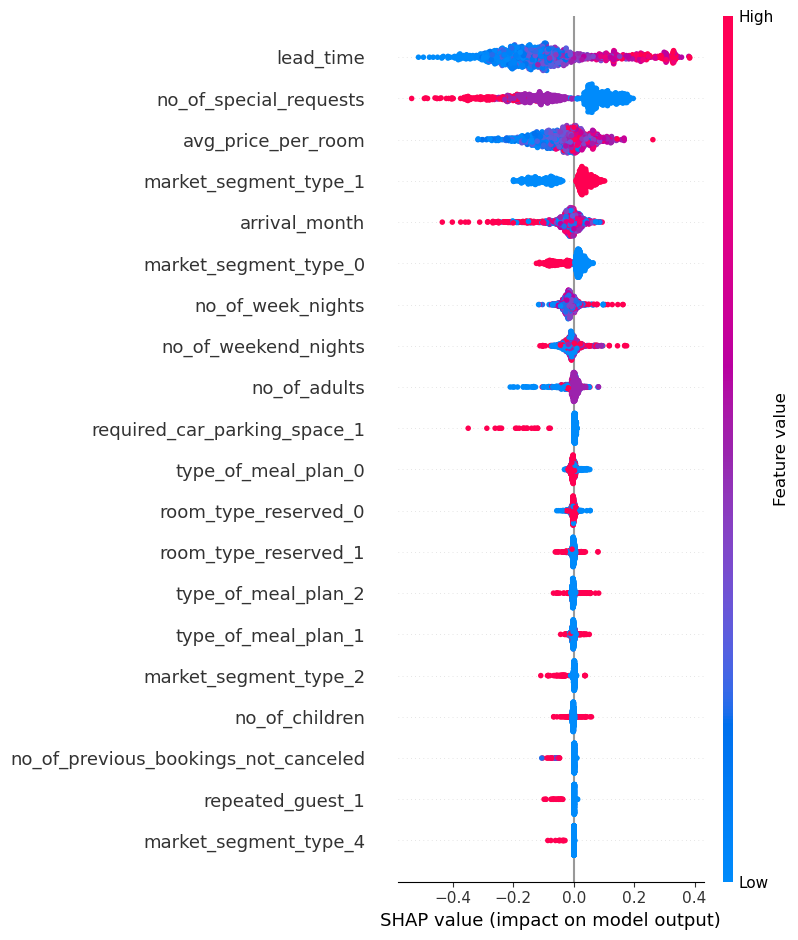

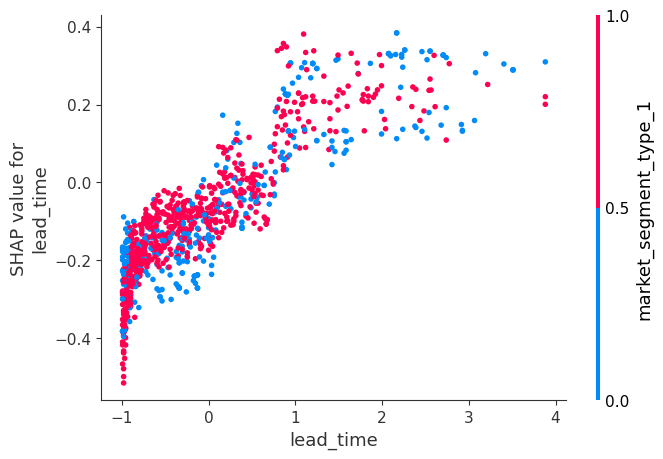

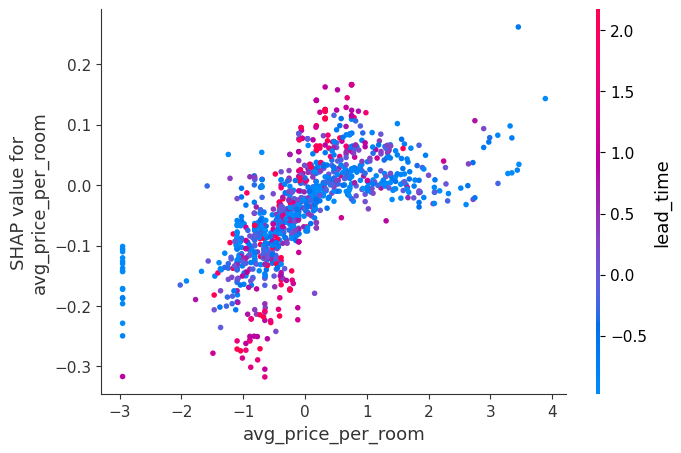

In [68]:
shap.summary_plot(train_rf_shap_values[1], pp_df.sample(n=1000, random_state = 111))
shap.dependence_plot("lead_time", train_rf_shap_values[1], pp_df.sample(n=1000, random_state = 111))
shap.dependence_plot("avg_price_per_room", train_rf_shap_values[1], pp_df.sample(n=1000, random_state = 111))

**Insights summary**:

-   **First plot**: The analysis reveals a strong correlation between lead_time values and the corresponding shap values. High lead_time values tend to have high shap values, while low lead_time values are associated with low shap values. This indicates that high lead_times are more likely to predict the outcome 1, whereas lower lead_times are more likely to predict 0. Similarly, for the no_of_special_requests feature, it is observed that high values tend to have low shap values, indicating that high no_of_special_requests are more likely to predict 0, while lower values are more likely to predict 1. Additionally, the analysis shows a similar pattern for the avg_price_per_room feature. High avg_price_per_room values have high shap values, indicating a higher likelihood of predicting 1, whereas low avg_price_per_room values have low shap values, suggesting a higher likelihood of predicting 0. Furthermore, the required_car_parking_space_1 feature has low shap values for high values, meaning that high required_car_parking_space_1 values are more likely to predict 1, while lower values are more likely to predict 0.

-   **Second plot**: The majority of data points in the graph correspond to market_segment_type_1. Additionally, there is a positive relationship between the lead_time values and their respective shap values, suggesting that as lead_time increases, so does its impact on the prediction. Non-market_segment_type_1 data points are mostly concentrated near the bottom of the graph, with a few outliers at the top.

-   **Third plot**: The graph indicates a mixed proportion of high and low lead_time values among the data points. Moreover, there is a positive correlation between the avg_price_per_room values and their corresponding shap values, indicating that higher avg_price_per_room values have a greater impact on the prediction.

#### Feature selection:

We will use RFECV to select the number of features to use in our model. It uses cross-validation to select number of features.


In [69]:
model = RandomForestClassifier(n_estimators = 200, max_depth=20, class_weight = {0: 1, 1: 3})
rfe_cv = RFECV(model, cv=10,n_jobs=-1)
rfe_cv.fit(X_train_pp, y_train)

print('Original number of features:', X_train_pp.shape[1])
print('Number of selected features:', sum(rfe_cv.support_), '\n\n')
print("Selected features: ", np.array(column_names)[rfe_cv.support_])

Original number of features: 28
Number of selected features: 18 


Selected features:  ['no_of_adults' 'no_of_children' 'no_of_weekend_nights'
 'no_of_week_nights' 'lead_time' 'avg_price_per_room'
 'no_of_special_requests' 'arrival_month' 'type_of_meal_plan_0'
 'type_of_meal_plan_1' 'type_of_meal_plan_2' 'room_type_reserved_0'
 'room_type_reserved_1' 'market_segment_type_0' 'market_segment_type_1'
 'market_segment_type_2' 'required_car_parking_space_1' 'repeated_guest_1']


As seen from the results, we have managed to reduce the number of features considerably (by half). Next, we will use this to check whether our model has improved or how much it improved.


In [70]:
new_train = rfe_cv.transform(X_train_pp)

print('accuracy scores:\n \n', mean_std_cross_val_scores(
    model, new_train, y_train, return_train_score=True, scoring ="accuracy"
),'\n \n','f1 scores:\n \n', mean_std_cross_val_scores(
    model, new_train, y_train, return_train_score=True, scoring ="f1"
))

accuracy scores:
 
 fit_time       1.767 (+/- 0.027)
score_time     0.084 (+/- 0.001)
test_score     0.884 (+/- 0.006)
train_score    0.986 (+/- 0.002)
dtype: object 
 
 f1 scores:
 
 fit_time       1.784 (+/- 0.066)
score_time     0.084 (+/- 0.001)
test_score     0.816 (+/- 0.005)
train_score    0.979 (+/- 0.001)
dtype: object


The accuracy scores and f1 scores increased very slightly but it is still a major improvement since our model is much simpler and considers lower parameters.

We have a proper model and have selected important features to train our model. Now, we will check how the model works on unseen datasets.

## Results:


In [71]:
model.fit(new_train,y_train)
new_test = preprocessor.transform(X_test)
new_test = rfe_cv.transform(new_test)

accuracy_testscore = model.score(new_test, y_test)
f1_testscore = f1_score(y_test, model.predict(new_test))
print("Accuracy: " + str(accuracy_testscore))
print("F1 score: " + str(f1_testscore))

Accuracy: 0.8869900771775082
F1 score: 0.827972027972028


From the train and test scores above: \* It has good test scores meaning it effectively classifies the data into their respective classes. \* The test scores agree with the validation scores from before. \* The test values are overfit. The predictions have high variance among them but low bias. \* The difference in train/test value means the model might not generalize well to new unseen data.

### Model caveats:

Throughout the project, the models created and methods used might not be best and the following results might not be perfect. Having said that, the following caveats can be inferred:

-   Generalizability: The significant difference between train accuracy/F1 score and test F1 accuracy/F1 score means that the model could be overfitting the training data. As a result, it might not generalize well to unseen data. This is mainly due to the fact we are using an ensemble model and other steps we took to optimize it such as RFECV, random search.
-   Suboptimal search results: Using grid search instead of random search could have provided better performing parameters since it is an exhaustive search. The hyperparameters found might be suboptimal compared to what we could have found using grid search.
-   Time series relationships: The relationship between the features and booking_status can change across the years/different dates. Since we did not consider time series analysis, we might have missed underlying patterns in the data, resulting in suboptimal model performance.
-   Complexity: Since we used an ensemble model, the model is complex and requires high computational power. Therefore, it is harder to understand or interpret the model, and its training time is also higher than usual.
-   Non-important features: RFECV might not have identified all the redundant features, which can increase model complexity and negatively impact the its performance.

Overall, the model still works as an useful tool to assist the hotel owners in better understanding whether a customer will honor the reservation or cancel it. Although the model is far from perfect, it can always be improved or further optimized. Training the model with new data sets occasionally will also improve the models performance in making informed decisions about managing hotel reservations.

<br><br>